In [1]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers
import imp

In [2]:
%matplotlib inline

# Spin system on tree network

### inter_H -> random external fields

### j_start -> values of ferromagnet interactions

We generate a tree:
1. ordered from a root
2. non-ordered (the same nodes are swapped)

In [3]:
Degree = 3 # degree
Height = 3 # Height of the tree

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


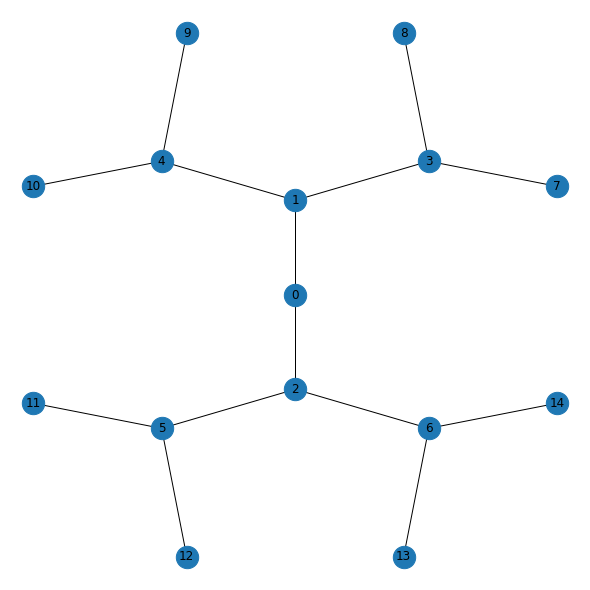

[[12, 3], [4, 6], [2, 8]]


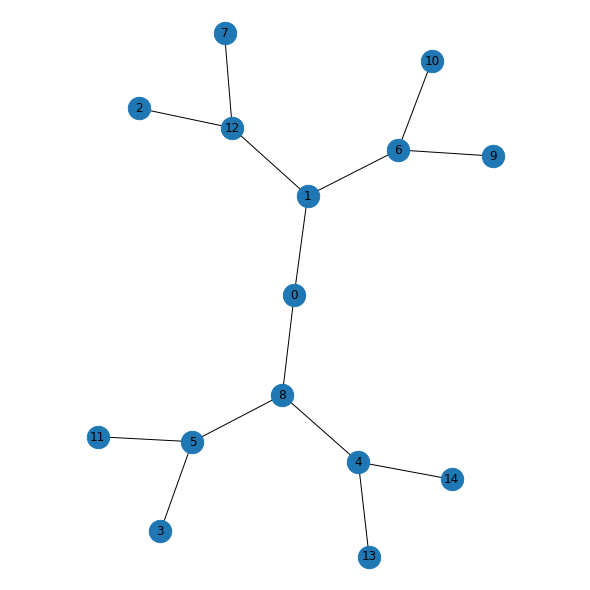

In [4]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

inter_H = 0
H = inter_H * (2.* np.random.random(N) - 1)
#H = np.zeros(N)

num_swap = 3
J_interaction_rand, H_rand = graph_gen.order_rand(N, 
                                                  J_interaction, 
                                                  H, num_swap=num_swap)

graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(0.1,2,4e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.

In [5]:
import model
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

In [6]:
beta = 0.2
tree.exact(beta)
tree_rand.exact(beta);

beta: 0.2, Fe: -3.558 Energy: -0.184 M: 0.0 S: 0.6753.16
beta: 0.2, Fe: -3.558 Energy: -0.184 M: 0.0 S: 0.6753.20


# Neural network solutions
## ordered case

In [7]:
import bp_nn
imp.reload(bp_nn)
bias = True
net = bp_nn.bp_nn(tree.N, tree, bias, z2=False)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
 )
net.compute_stat_is(beta, batch_size=5000)

 0.20 1663 fe: -3.558 +- 0.00010 E: -0.191, S: 0.674, M: 0.0219, B1 = 0.0000
free_energy: -3.558,  std_fe: 0.00000, mag_mean: -0.001, entropy: 0.676 energy: -0.179

tensor(-3.5585, dtype=torch.float64)

## random case

In [8]:
import bp_nn
imp.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.01, 
           max_step=1000,
               opt="adam")


 0.20 1000 fe: -3.556 +- 0.03011 E: -0.183, S: 0.675, M: 0.0209, B1 = 0.000

{'free_energy_mean': tensor(-3.5559, dtype=torch.float64),
 'free_energy_std': tensor(0.0301, dtype=torch.float64),
 'entropy_mean': tensor(0.6746, dtype=torch.float64, grad_fn=<DivBackward0>),
 'energy_mean': tensor(-0.1827, dtype=torch.float64),
 'mag': tensor([ 0.0060,  0.0120,  0.0240, -0.0240,  0.0340, -0.0120,  0.0180,  0.0280,
          0.0320, -0.0220,  0.0000,  0.0000,  0.0480, -0.0360, -0.0180]),
 'mag_mean': tensor(0.0209)}

In [9]:
net_rand.compute_stat_is(beta, batch_size=5000)


free_energy: -3.558,  std_fe: 0.00007, mag_mean: 0.014, entropy: 0.675 energy: -0.182

tensor(-3.5580, dtype=torch.float64)

# BP solution

In [10]:
import bp_solver
bp_sol = bp_solver.BP_solver(tree)

In [11]:
bp_sol.converge(beta)

fe: -3.558, ener: -0.184, M: 0.000, iter 5
